# 10. Frame Selected Matching

In [1]:
from src import *

## Description

We look in this section for the capacity of matching individuals using frame selected gradients.

GOAL: Compute accuracy of frame selected gradients versus movie

## Table of Contents
- [Frame selected emotion gradients](#comparison)

In [2]:
def matching_accuracy(database, target, net='Full', similarity='spearman'):
    """
    Compute for a set of gradients the accuracy of matching ID
    with varying IDs with a given target
    
    """
    subjects = list(database.keys())
    if net == 'Full':
        database_grad = [database[sub] for sub in subjects]
    else:
        database_grad = [database[sub][index2region[net]] for sub in subjects]

    matches = []
    for sidx, sub in enumerate(subjects):
        if net == 'Full':
            target_grad = target[sub]
        else:
            target_grad = target[sub][index2region[net]]

        # Method 1 for distance computing
        distances = [gradients_distance2(database_grad[i], target_grad, pmethod="L2", similarity=similarity)
                     for i in range(len(database_grad))]

        # Method 2 for distance computing
#             aligned_grad,_,score = procrustes_align(database_grad, ref=target_grad)
#             if np.sum(np.asarray(score) > 100) > 0: print('Warning: might not be well-aligned') #the choice of 100 is arbitrary and empirically motivated

#             distances = [gradients_distance(aligned_grad[i], target_grad, pmethod="L2") 
#                          for i in range(len(aligned_grad))]

        indexmatch = np.argsort(distances)[:1]
        bestmatch = [subjects[b] for b in indexmatch]
        matches.append(sub in bestmatch)    
    return np.mean(matches)
    
def matching_accuracy_selfgrid(database_gradients, net='Full', similarity='spearman'):
    """
    Compute for a set of gradients the accuracy of matching ID
    with varying IDs on all self combinations
    
    database_gradients<dict>
    """
    pred_grid = np.zeros((len(database_gradients), len(database_gradients)))
    labels = database_gradients.keys()
    targets = [database_gradients[lab] for lab in labels]
    
    for idxi, target in enumerate(tqdm(targets)):
        for idxj,j in enumerate(database_gradients):
            database = database_gradients[j]
            pred_grid[idxi,idxj]   = matching_accuracy(database, target, net=net, similarity=similarity)

    return pred_grid

<a class="anchor" id="comparison"></a>
## Frame selected (3 FA) gradients

In [3]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

In [4]:
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

Load frame selected and full movie gradients (individual level)

In [5]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/threshed_series/fa_global_treshed_series.pkl')

if 'Rest' in f_series: del f_series['Rest']
if 'Rest' in total_series: del total_series['Rest']

In [35]:
nbs = 4
splits = [list(total_series.keys())[len(total_series)//nbs * k:len(total_series)//nbs * (k+1)] 
          for k in range(nbs)]

print(splits)

[['ToClaireFromSonny', 'TheSecretNumber', 'Chatter'], ['LessonLearned', 'Payload', 'AfterTheRain'], ['Superhero', 'Sintel', 'TearsOfSteel'], ['BetweenViewing', 'BigBuckBunny', 'YouAgain']]


In [36]:
# compute threshed picked timeseries of same length
fa_gradients = {}
for bound in s25:
    fselected_series = f_series[2][bound] # POWER selection
    f_selected_gradients = {k:{} for k in range(0,len(splits))}

    for gidx, set_group in enumerate(splits):
        moviegroup_grad = {}
        for mname in set_group:
            tmp_dict = fselected_series[mname]
        
        
            for _id in tmp_dict:
                tmp_series = tmp_dict[_id]
                if _id not in moviegroup_grad:
                    moviegroup_grad[_id] = []
                moviegroup_grad[_id].append(tmp_series)
                
        for _id in moviegroup_grad:
            tmp_series = np.concatenate(moviegroup_grad[_id])
            
            fc_selects = FC(tmp_series)
            g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
            g_selects.fit(fc_selects)
            f_selected_gradients[gidx][_id] = g_selects.gradients_

    fa_gradients[bound] = f_selected_gradients

In [37]:
# # compute randomly picked timeseries of same length
# np.random.seed(19)

# rnd_movie_grads = {k:{} for k in fselected_series}
# for mname in fselected_series:
#     perc_left = fselected_series[mname]['S15'].shape[0]
#     tmp_dict = total_series[mname]
#     length = tmp_dict['S15'].shape[0]
#     start_idx = np.random.choice(np.arange(length-perc_left))
    
#     for _id in tmp_dict:
#         tmp_series = tmp_dict[_id]
#         if len(tmp_series) < 15: continue        
#         tmp_series = tmp_series[start_idx:start_idx+perc_left]

#         fc_selects = FC(tmp_series)
#         g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
#                             kernel=aff_kernel, random_state=rs)
#         g_selects.fit(fc_selects)
#         rnd_movie_grads[mname][_id] = g_selects.gradients_

In [38]:
grid1 = matching_accuracy_selfgrid(fa_gradients[(0,25)])
grid2 = matching_accuracy_selfgrid(fa_gradients[(25,50)])
grid3 = matching_accuracy_selfgrid(fa_gradients[(50,75)])
grid4 = matching_accuracy_selfgrid(fa_gradients[(75,100)])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [39]:
grid4

array([[1.        , 0.26666667, 0.56666667, 0.4       ],
       [0.23333333, 1.        , 0.3       , 0.33333333],
       [0.56666667, 0.23333333, 1.        , 0.46666667],
       [0.46666667, 0.13333333, 0.56666667, 1.        ]])

In [40]:
grid3

array([[1.        , 0.3       , 0.6       , 0.63333333],
       [0.5       , 1.        , 0.53333333, 0.6       ],
       [0.7       , 0.53333333, 1.        , 0.76666667],
       [0.73333333, 0.63333333, 0.6       , 1.        ]])

In [41]:
grid2

array([[1.        , 0.7       , 0.63333333, 0.56666667],
       [0.7       , 1.        , 0.56666667, 0.5       ],
       [0.6       , 0.6       , 1.        , 0.53333333],
       [0.66666667, 0.76666667, 0.63333333, 1.        ]])

In [42]:
grid1

array([[1.        , 0.63333333, 0.43333333, 0.46666667],
       [0.53333333, 1.        , 0.53333333, 0.6       ],
       [0.46666667, 0.66666667, 1.        , 0.5       ],
       [0.4       , 0.6       , 0.5       , 1.        ]])

In [27]:
grid1 = matching_accuracy_selfgrid(fa_gradients[(0,33)])
grid2 = matching_accuracy_selfgrid(fa_gradients[(33,66)])
grid3 = matching_accuracy_selfgrid(fa_gradients[(66,100)])

# grid4 = matching_accuracy_selfgrid(rnd_movie_grads)

In [ ]:
sns.kdeplot(grid1.flatten())
sns.kdeplot(grid2.flatten())
sns.kdeplot(grid3.flatten())
sns.kdeplot(grid4.flatten())
plt.xlim(0,0.7)

<AxesSubplot:title={'center':'identifiability accuracy'}>

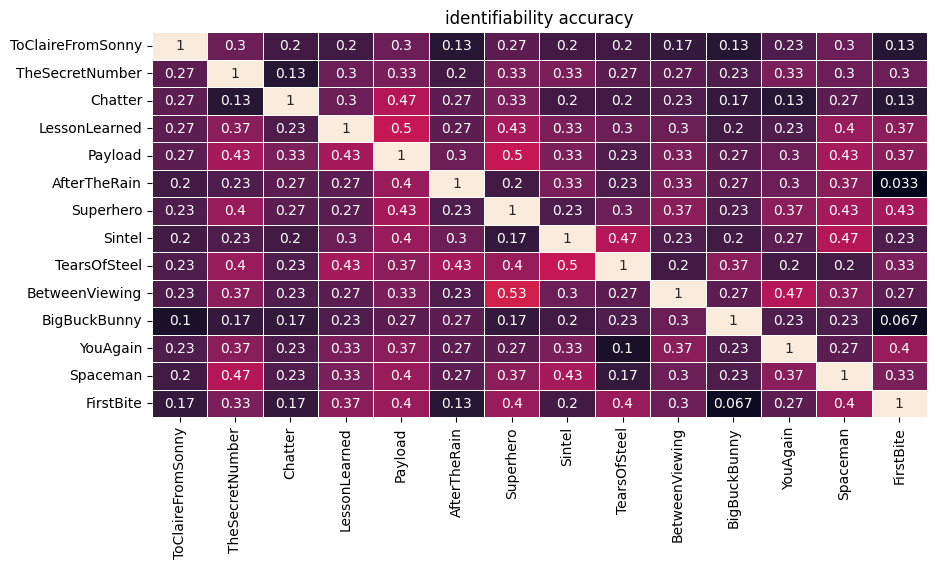

In [70]:
plt.figure(figsize=(10,5))
plt.title("identifiability accuracy")
x_axis_labels = list(fa_gradients[(0,33)].keys())
sns.heatmap(grid1, linewidth=0.5,  annot=True, xticklabels=x_axis_labels, yticklabels=x_axis_labels, cbar=False)

#### Compute Matching accuracies

#### Example Pair

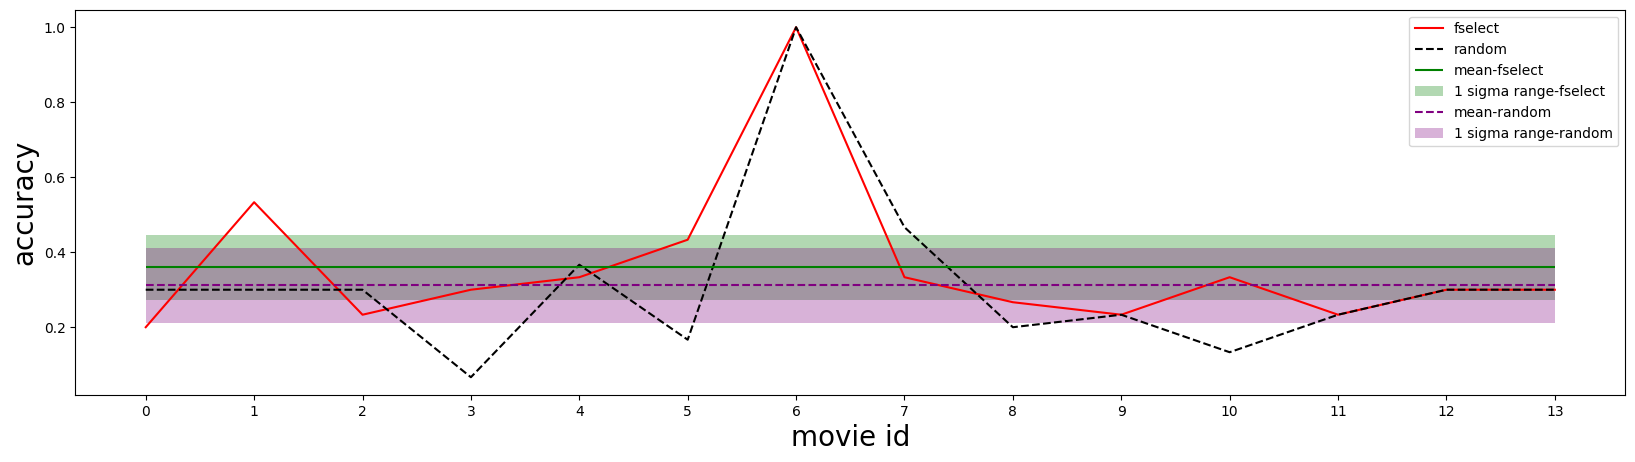

In [47]:
labels = []
for k in list(all_gradients.keys()):
    if len(k.split('_')) == 1:
        labels.append(k[:3] + '_r')
    else:
        labels.append(k[:3] + '_f')
fig, ax = plt.subplots(1, figsize=(20,5))

pred1 = pred_grid[0][:len(all_gradients)//2]
pred2 = pred_grid[1][len(all_gradients)//2:]
wpred1 = np.delete(pred1, np.where(pred1 == 1))
wpred2 = np.delete(pred2, np.where(pred2 == 1))

ax.plot(pred1, label='fselect', color='r')
ax.plot(pred2, label='random', color='k', linestyle='--')

ax.hlines(pred1.mean(),0,len(all_gradients)//2-1,label='mean-fselect', color='g')
ax.fill_between(np.arange(len(all_gradients)//2), pred1.mean()-wpred1.std(), 
                   pred1.mean()+wpred1.std(), facecolor='green', alpha=0.3,
                label='1 sigma range-fselect')
ax.hlines(pred2.mean(),0,len(all_gradients)//2-1,label='mean-random',color='purple', linestyle='--')
ax.fill_between(np.arange(len(all_gradients)//2), pred2.mean()-wpred2.std(), 
                   pred2.mean()+wpred2.std(), facecolor='purple', alpha=0.3,
                label='1 sigma range-random')
ax.set_ylabel('accuracy', fontsize=20)
ax.set_xticks(np.arange(len(all_gradients)//2))
ax.set_xticks(np.arange(len(all_gradients)//2))
ax.set_xlabel('movie id', fontsize=20)
# ax[0].set_ylim(0.1,1)
# ax[1].set_ylim(0.1,1)
ax.legend()

<a class="anchor" id="comparison"></a>
## Frame selected (3 FA combine (valence arousal) ) gradients

In [4]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

In [3]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/threshed_series/fa_global_cross_treshed_series.pkl')

if 'Rest' in f_series: del f_series['Rest']
if 'Rest' in total_series: del total_series['Rest']

In [9]:
# compute threshed picked timeseries of same length
fa_gradients = {}
S = list(f_series.keys())
for bound in tqdm(S):
    fselected_series = f_series[bound]
    f_selected_gradients = {k:{} for k in fselected_series}

    for mname in fselected_series:
        tmp_dict = fselected_series[mname]
        

        for _id in tmp_dict:
            tmp_series = tmp_dict[_id]
            if len(tmp_series) < 15: continue
            fc_selects = FC(tmp_series)
            g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
            g_selects.fit(fc_selects)
            f_selected_gradients[mname][_id] = g_selects.gradients_
    fa_gradients[bound] = f_selected_gradients

  0%|          | 0/25 [00:00<?, ?it/s]

In [21]:
# quick fix delete movies
tmp = fa_gradients[(80,100,80,100)]
grad1 = {}
movienames = tmp.keys()

c=0 
for mname in movienames:
    if len(tmp[mname]) != 0:
        c += 1
        grad1[mname] = tmp[mname]


grid1 = matching_accuracy_selfgrid(grad1)
# grid2 = matching_accuracy_selfgrid(fa_gradients[(33,66)])
# grid3 = matching_accuracy_selfgrid(fa_gradients[(66,100)])

  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
import os

In [26]:
os.path.abspath('./')

'/home/chchan/connectivity_gradient_analysis'

In [22]:
c

3

In [20]:
tmp

{'ToClaireFromSonny': {},
 'TheSecretNumber': {},
 'Chatter': {},
 'LessonLearned': {},
 'AfterTheRain': {},
 'Superhero': {},
 'Sintel': {},
 'TearsOfSteel': {'S04': array([[-6.0075879 , -0.75342845, -1.93089469],
         [-3.58627991,  5.92810648,  3.4012701 ],
         [-2.75949133,  6.06660048, -1.40618014],
         ...,
         [ 1.37015383,  6.68632479, -3.61426321],
         [ 0.65425549, -3.56449838, -0.0849562 ],
         [ 0.54551102, -1.44660825, -1.97106729]]),
  'S32': array([[ 9.09327473, -3.8196298 , -1.35309538],
         [ 5.35015234,  1.88975187, -2.46067755],
         [10.70966833, -3.81062204, -0.29783575],
         ...,
         [15.50502408, -0.67296106,  2.08286919],
         [14.22941694, -1.35838393,  1.25212279],
         [ 2.70236781, -3.97197271, -0.67308186]]),
  'S03': array([[ 1.05252755e+01, -1.14082921e+00, -4.54778852e-01],
         [ 8.18188927e+00, -1.89997059e+00, -1.79403696e+00],
         [ 7.56346158e+00, -2.68504755e+00, -9.19556550e-01],
   

In [19]:
grid1

array([[1.        , 0.1       , 0.06666667],
       [0.1       , 1.        , 0.06666667],
       [0.13333333, 0.06666667, 1.        ]])

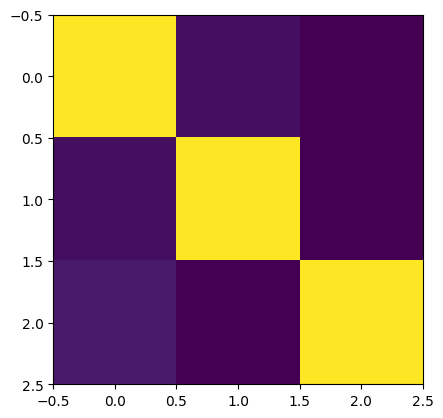

In [18]:
plt.imshow(grid1)

NOTE: check randomized size for bins, intersection not constant size

In [ ]:
# compute randomly picked timeseries of same length
np.random.seed(19)

rnd_movie_grads = {k:{} for k in fselected_series}
for mname in fselected_series:
    perc_left = fselected_series[mname]['S15'].shape[0]
    tmp_dict = total_series[mname]
    length = tmp_dict['S15'].shape[0]
    start_idx = np.random.choice(np.arange(length-perc_left))
    
    for _id in tmp_dict:
        tmp_series = tmp_dict[_id]
        if len(tmp_series) < 15: continue        
        tmp_series = tmp_series[start_idx:start_idx+perc_left]

        fc_selects = FC(tmp_series)
        g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
        g_selects.fit(fc_selects)
        rnd_movie_grads[mname][_id] = g_selects.gradients_